# This notebook explore predition of item price based on item description using LLM out of the box without fine tuning.

In [1]:
import sys
import os
# Add the project root to sys.path
project_root = os.path.abspath("..")  # Move one level up to the project root
if project_root not in sys.path:
    sys.path.insert(0, project_root)# change working directory to project root
import os
import re
import math
import json
import random
import pickle
import numpy as np
import pandas as pd
from utils.items import Item
from utils.tester import Tester
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from huggingface_hub import login
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

%matplotlib inline


/opt/homebrew/Caskroom/miniconda/base/envs/llm-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
openai_llm = ChatOpenAI(model="gpt-4o-mini")
anthropic_llm = ChatAnthropic(model="claude-3-sonnet-20240229")

In [3]:
HF_TOKEN = os.getenv('HUGGINGFACE_TOKEN')

In [4]:
os.getcwd()

'/Users/cshyang/Documents/Coding Repositories/LLM/LLM Finetuning/finetune_llm_openai/notebooks'

In [5]:
# Add an alias in sys.modules
os.chdir("..")
sys.modules['items'] = sys.modules['utils.items']

with open('data/train.pkl', 'rb') as f:
    train = pickle.load(f, encoding='latin1')

with open('data/test.pkl', 'rb') as f:
    test = pickle.load(f)

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

def messages_for(item):
    system_message = "You estimate prices of items. reply only with the price, no explaination."
    user_prompt = item.test_prompt().replace(" to the nearest dollor", "").replace("\n\nPrice is $", "")
    return [
        SystemMessage(content=system_message),
         HumanMessage(content=user_prompt),
         AIMessage(content="Price is $")
    ]

In [7]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [8]:
def openai_get_price(item) :
    response = openai_llm.invoke(messages_for(item), max_tokens=5, seed=42).content
    # Extract the price from the response
    return get_price(response)

openai_get_price(test[0])

50.0

1: Guess: $50.00 | Truth: $97.99 | Error: $47.99 | SLE: $0.44 | Item: Aukilus LCD Display Touch Screen Digitiz...
2: Guess: $230.00 | Truth: $116.92 | Error: $113.08 | SLE: $0.45 | Item: Depo 312-19C6R-AF Replacement Auto Part ...
3: Guess: $400.00 | Truth: $410.00 | Error: $10.00 | SLE: $0.00 | Item: Digital Check CheXpress Scanner WITHOUT ...
4: Guess: $100.00 | Truth: $68.76 | Error: $31.24 | SLE: $0.14 | Item: Greenwald Industries 8-1170 Genuine OEM ...
5: Guess: $200.00 | Truth: $298.59 | Error: $98.59 | SLE: $0.16 | Item: Innovative Mounts 90750-85A Black Bushin...
6: Guess: $200.00 | Truth: $228.99 | Error: $28.99 | SLE: $0.02 | Item: A-Premium Hydro-Boost Power Brake Booste...
7: Guess: $400.00 | Truth: $409.95 | Error: $9.95 | SLE: $0.00 | Item: B&M 70418 Tork Master 2400 Torque Conver...
8: Guess: $35.00 | Truth: $118.99 | Error: $83.99 | SLE: $1.45 | Item: Boxes Fast BFMFL1294K Deluxe Literature ...
9: Guess: $30.00 | Truth: $34.99 | Error: $4.99 | SLE: $0.02 | Item: 72" Hom

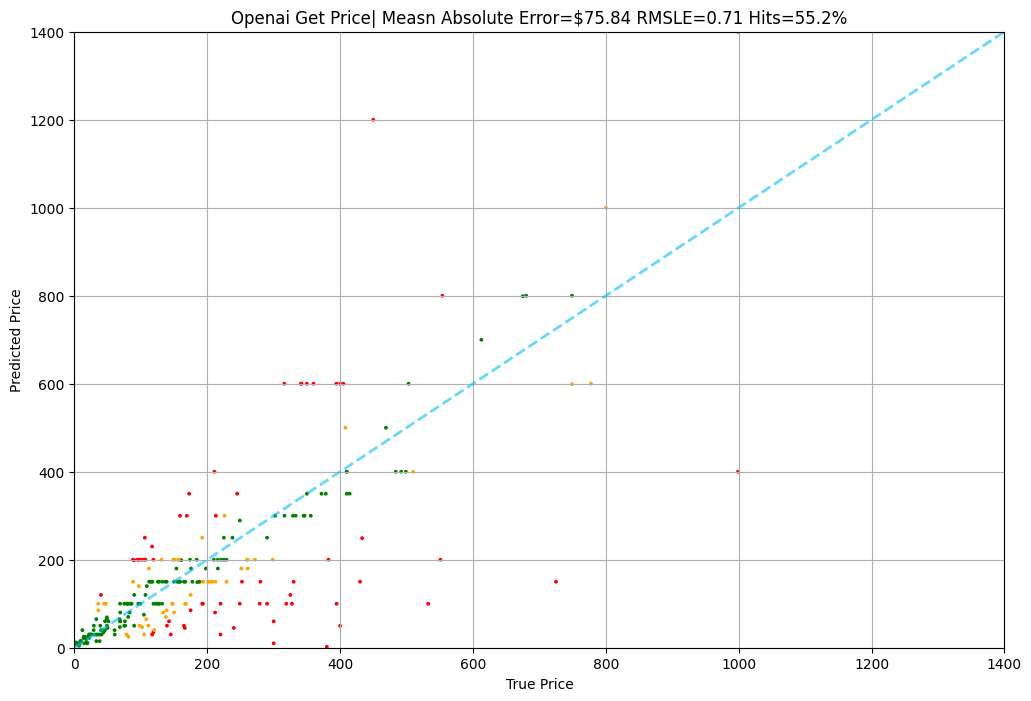

In [9]:
Tester.test(openai_get_price, test)